In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
import matplotlib

## Utility functions

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw detected boxes on the image
    """
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color = color, thickness = thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

def convert_color(img, color_space='RGB'):
    """
    Convert RGB to any given color space
    """
    if color_space == 'HSV':
        color = cv2.COLOR_RGB2HSV
    elif color_space == 'HLS':
        color = cv2.COLOR_RGB2HLS
    elif color_space == 'YUV':
        color = cv2.COLOR_RGB2YUV
    elif color_space == 'LUV':
        color = cv2.COLOR_RGB2LUV
    elif color_space == 'YCrCb':
        color = cv2.COLOR_RGB2YCrCb
    else:
        color = cv2.COLOR_RGB2BGR
        
    if color_space != 'RGB':
        res_img = cv2.cvtColor(img, color)
    else:
        res_img = np.copy(img)
        
    return res_img 

def scale_rgb_to_255(img):
    """
    Scale image from [0-1] to [0-255] range
    """
    image = (img * 255).astype(np.uint8)
    return image 


def get_channels(image, channels='ALL'):
    """
    Get specified channels list to extract features
    """
    if channels == 'ALL': 
        channles_set = range(image.shape[2])
    else:
        channles_set = channels
        
    return channles_set

## Drawing and loading utilites

In [3]:
def draw_color_hist(features, bincen, color_labels=list("RGB")):
    """
    Draw color channels histograms
    """
    n_channel_features = len(features) // 3
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, features[0:n_channel_features])
    plt.xlim(0, 256)
    plt.title('{} Histogram'.format(color_labels[0]))
    plt.subplot(132)
    plt.bar(bincen, features[n_channel_features : 2*n_channel_features])
    plt.xlim(0, 256)
    plt.title('{} Histogram'.format(color_labels[1]))
    plt.subplot(133)
    plt.bar(bincen, features[2*n_channel_features : 3*n_channel_features])
    plt.xlim(0, 256)
    plt.title('{} Histogram'.format(color_labels[2]))
    fig.tight_layout()
    plt.show()
    
    
def load_image(image_name):
    """
    Load image in RGB format with [0-255] range for both jpg and png.
    """
    img = cv2.imread(image_name)
    res_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return res_img

def show_image(image, cmap=None):
    """
    Display image
    """
    plt.imshow(image)
    plt.show()

## Color features

In [4]:
def color_hist(image, nbins=32, bins_range=(0, 256), channels='ALL'):
    """
    Calculate color histogram feature
    """    
    #get channels
    channels_set = get_channels(image, channels)
    channel_features = []
    bin_centers = None
    
    #for each channels calculate histogram using numpy
    for channel in channels_set:
        hist = np.histogram(image[:,:,channel], bins=nbins, range=bins_range)
        channel_features.append(hist[0])
        
        if bin_centers is None:
             bin_centers = (hist[1][1:] + hist[1][0:-1]) / 2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(channel_features)    
   
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, bin_centers

def bin_spatial(img, size=(32, 32)):
    """
    Calculate spatial bin coolor features
    """
    features = cv2.resize(img, size).ravel()   
    return features

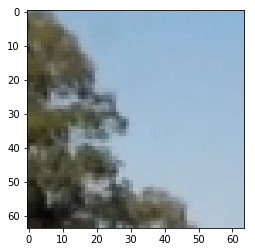

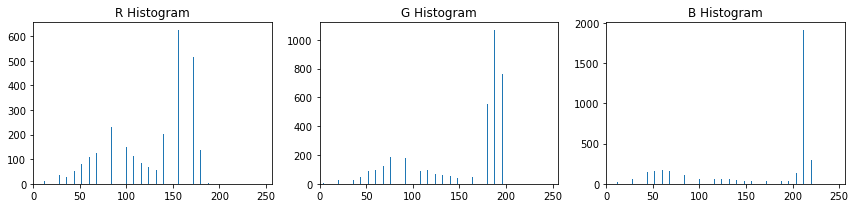

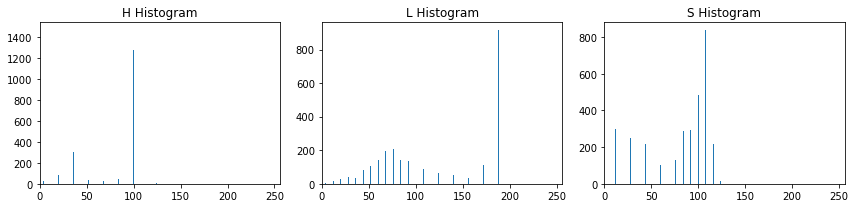

In [5]:
#sky color historgram
img = load_image("test_images/2.png")
show_image(img)

features, bincen = color_hist(img, nbins=32, bins_range=(0, 256))
draw_color_hist(features, bincen)

image2 = convert_color(img, 'HLS')

features, bincen = color_hist(image2, nbins=32, bins_range=(0, 256))
draw_color_hist(features, bincen, color_labels=list("HLS"))


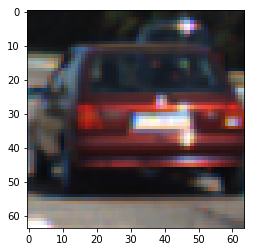

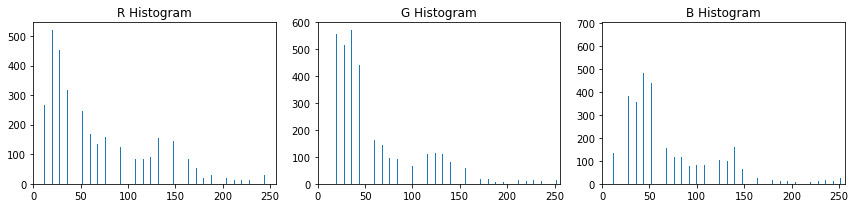

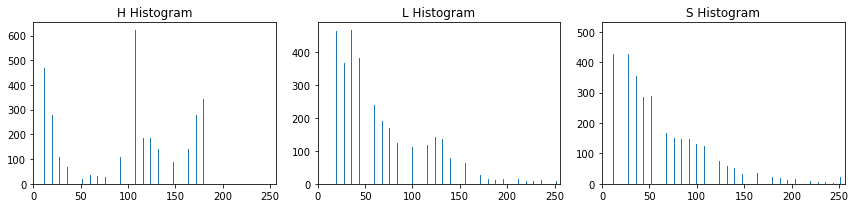

In [6]:
img = load_image("test_images/53.png")

show_image(img)
features, bincen = color_hist(img, nbins=32, bins_range=(0, 256))
draw_color_hist(features, bincen)

image2 = convert_color(img, 'HLS')

features, bincen = color_hist(image2, nbins=32, bins_range=(0, 256))
draw_color_hist(features, bincen, color_labels=list("HLS"))

## Hog features

In [7]:
from skimage.feature import hog

#HOG features
def hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True, block_norm='L2-Hys'):
    """
    Get HOG features for single channel
    """
    if vis:
        features, hog_image = hog(img, orientations=
                            orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=
                            (cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec, block_norm = block_norm)

        return features, hog_image  
    else:
        features = hog(img, orientations=
                            orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=
                            (cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec, block_norm = block_norm)

        return features 

def extract_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True, block_norm='L2-Hys', channels='ALL'):
    """
    Get HOG features for the image using multiple channels
    """
    features = []
    
    channels_set = get_channels(img, channels)
    
    for channel in channels_set:  
        channel_features = hog_features(img[:,:,channel], orient, pix_per_cell = pix_per_cell,
                                        cell_per_block = cell_per_block, vis=False, feature_vec=True, block_norm=block_norm)
        features.append(channel_features)
        
    return np.ravel(features)

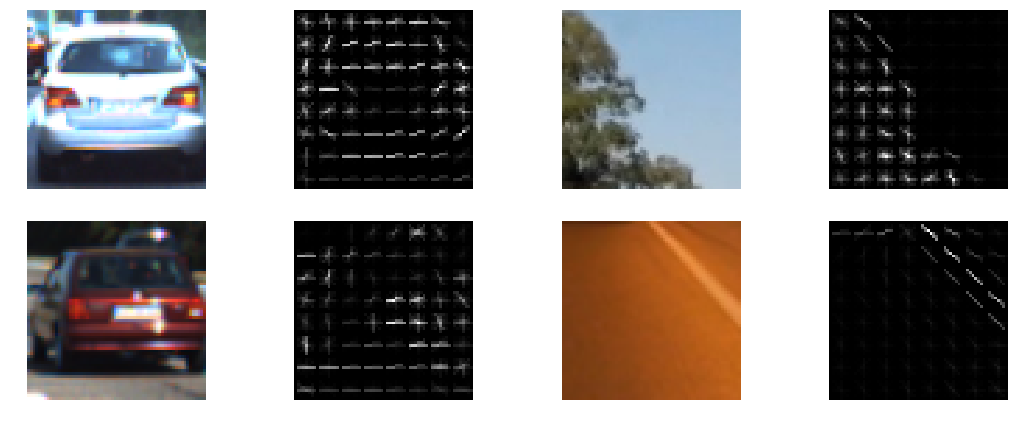

In [8]:
#visualize HOG feature

img1 = load_image("test_images/31.png")
img_1 = convert_color(img1, 'HSV')

features, hog_image1 = hog(img1[:,:,1], orientations=12, pixels_per_cell=(8, 8), cells_per_block=
                          (3, 3), visualise=True, feature_vector=False, block_norm='L2')


img2 = load_image("test_images/2.png")
img_2 = convert_color(img2, 'HSV')

features, hog_image2 = hog(img2[:,:,1], orientations=12, pixels_per_cell=(8, 8), cells_per_block=
                          (3, 3), visualise=True, feature_vector=False, block_norm='L2')


img3 = load_image("test_images/53.png")
img_3 = convert_color(img3, 'HSV')

features, hog_image3 = hog(img3[:,:,1], orientations=12, pixels_per_cell=(8, 8), cells_per_block=
                          (3, 3), visualise=True, feature_vector=False, block_norm='L2')

img4 = load_image("test_images/8.png")
img_4 = convert_color(img4, 'HSV')

features, hog_image4 = hog(img4[:,:,1], orientations=12, pixels_per_cell=(8, 8), cells_per_block=
                          (3, 3), visualise=True, feature_vector=False, block_norm='L2')

fig, axies = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
fig.tight_layout()

axies[0][0].imshow(img1)
axies[0][0].set_axis_off()  

axies[0][1].imshow(hog_image1, cmap='gray')
axies[0][1].set_axis_off()  

axies[0][2].imshow(img2)
axies[0][2].set_axis_off()  

axies[0][3].imshow(hog_image2, cmap='gray')
axies[0][3].set_axis_off()  

axies[1][0].imshow(img3)
axies[1][0].set_axis_off()  

axies[1][1].imshow(hog_image3, cmap='gray')
axies[1][1].set_axis_off()  

axies[1][2].imshow(img4)
axies[1][2].set_axis_off()  

axies[1][3].imshow(hog_image4, cmap='gray')
axies[1][3].set_axis_off()  

plt.show()

## Define feature definition class and feature extration methods

In [9]:
class Spatial_features_definition():
    """
    Class to store settings for the spartial features
    """   
    def __init__(self):
        self.color_space = 'RGB'
        self.spatial_size = (32, 32)  

class Histogram_features_definition():
    """
    Class to store settings for the color histogram features
    """   
    def __init__(self):
        self.color_space = 'RGB'
        self.hist_bins=32
        self.hist_range=(0, 256)
        self.channels = 'ALL'
        
class Hog_features_definition():
    """
    Class to store settings for the Hog feature
    """   
    def __init__(self):
        self.color_space = 'RGB'
        self.orient = 9,
        self.pix_per_cell = 6
        self.cell_per_block = 3,
        self.feature_vec = True,
        self.block_norm='L2-Hys', 
        self.channels = 'ALL'     
        
class Features_definition():
    """
    Class to store full feature definitions settings
    """   
    def __init__(self):
        self.spatial_definition = [Spatial_features_definition()]
        self.histogram_definition = [Histogram_features_definition()]
        self.hog_definition = [Hog_features_definition()]

In [10]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

def extract_features_single(image, definition):
    """
    Extract features according to the features definition specified
    from the single image
    """ 
   
    # Create a list to append feature vectors to
    features = []
    
    #define all color spaces required and prepare converted images
    color_spaces = []
    color_spaces.extend([x.color_space for x in definition.spatial_definition])
    color_spaces.extend([x.color_space for x in definition.histogram_definition])
    color_spaces.extend([x.color_space for x in definition.hog_definition])
    color_spaces = set(color_spaces)
    
    #prepare converted images
    images = {}
    
    for color_space in color_spaces:
        res = convert_color(image, color_space)
        images[color_space] = res
        
    #prepare spartial features
    for def_ in definition.spatial_definition:
        working_image = images[def_.color_space]
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(working_image, size=def_.spatial_size)
        features.append(spatial_features)
   
    #prepare histogram features
    for def_ in definition.histogram_definition:
        working_image = images[def_.color_space]

        # Apply bin_spatial() to get spatial color features
        histogram_features, _ = color_hist(working_image, nbins=def_.hist_bins, 
                                           bins_range=def_.hist_range, channels = def_.channels)
        features.append(histogram_features)
    
    
    #prepare hog features
    for def_ in definition.hog_definition:
        working_image = images[def_.color_space]
        
        hog_features = extract_hog_features(working_image, orient=def_.orient,
                                                pix_per_cell=def_.pix_per_cell, cell_per_block = def_.cell_per_block,
                                                block_norm=def_.block_norm, channels=def_.channels)
        features.append(hog_features)
    
    # Append the new feature vector to the features list
    features = np.concatenate(features)
    
    # Return list of feature vectors
    return features


def extract_features(imgs, definition):
    """
    Extract features according to the features definition specified
    from the list of images
    """ 
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        
        # Read in each one by one
        image = load_image(file)
    
        #extract features
        res_features = extract_features_single(image, definition)
       
        # Append the new feature vector to the features list
        features.append(res_features)
        
    # Return list of feature vectors
    return features 

## Prepare Training Dataset

In [11]:
def get_features(car_images, no_car_images, definition):
    """
    Extract features from the cars and no-cars images
    """ 
        
    #prepare image features using definition
    car_features = extract_features(car_images, definition)
    not_car_features = extract_features(no_car_images, definition)
    
    car_features = np.array(car_features)
    not_car_features = np.array(not_car_features)
    
    # Create an array stack of feature vectors
    X = np.concatenate((car_features, not_car_features))  

    # Fit scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
    
    return X, y, X_scaler 

# Train classfier

In [12]:
def train(cls, X, y, random_state=0):
    """
    Train provided classifier with providede data
    """ 
  
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)
    
    # Check the training time to fit classifier
    t_start = time.time()
    cls.fit(X_train, y_train)
    t_end = time.time()
    
    training_time = round(t_end - t_start, 2)
    
    accuracy = round(cls.score(X_test, y_test), 6)
    
    return accuracy, training_time

def predict_for_image(image, definition, scaler, cls):
    """
    Predict class for single image
    """ 
    features = extract_features_single(image, definition)
    scaled_features = scaler.transform(features.reshape(1, -1))
    res = cls.predict(scaled_features)
    
    return np.uint8(res)

## Get image files for training

In [13]:
def load_small_dataset():
    """
    Load limited image dataset for training
    """ 

    images = glob.glob('data_small/**/**/*.jpeg')

    small_cars = []
    small_notcars = []

    for image in images:
        if 'image' in image or 'extra' in image:
            small_notcars.append(image)
        else:
            small_cars.append(image)

    print('Cars count: {}'.format(len(small_cars)))
    print('No-cars count: {}'.format(len(small_notcars)))
    
    return small_cars, small_notcars

def load_full_dataset():
    """
    Load full dataset for training
    """  

    images_v = glob.glob('data/vehicles/**/*.png')
    images_nv = glob.glob('data/non-vehicles/**/*.png')

    cars = []
    notcars = []

    for image in images_v:
        cars.append(image)

    for image in images_nv:
        notcars.append(image)
        
    print('Cars count: {}'.format(len(cars)))
    print('No-cars count: {}'.format(len(notcars)))
    
    return cars, notcars

## Prepare features definition and image data to train classifier

In [14]:
#setup features definition to extract features

definition = Features_definition()
definition.spatial_definition = []
definition.histogram_definition = []

hog_definition = Hog_features_definition()
hog_definition.color_space = 'YUV'
hog_definition.orient = 9
hog_definition.pix_per_cell = 8
hog_definition.cell_per_block = 2
hog_definition.block_norm='L2' 
hog_definition.channels = [1]

hog_definition2 = Hog_features_definition()
hog_definition2.color_space = 'HSV'
hog_definition2.orient = 9
hog_definition2.pix_per_cell = 8
hog_definition2.cell_per_block = 2
hog_definition2.block_norm='L2' 
hog_definition2.channels = [1, 2]

definition.hog_definition = [hog_definition, hog_definition2]

# Train Classifier

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#get image files
cars, notcars = load_full_dataset()

#get features from the image list
t_start = time.time()

X, y, scaler = get_features(cars, notcars, definition)

t_end = time.time()
training_time = round(t_end - t_start, 2)

print(training_time, 'Seconds to extract features...')
 
print('Number of images:', X.shape[0])

print('Feature vector length:', len(X[0]))

#create classifier
svc = LinearSVC(C=1)

#svc = LogisticRegression()

#svc = DecisionTreeClassifier(random_state = 3)
#svc = AdaBoostClassifier(random_state = 3, base_estimator = svc, algorithm='SAMME')

rand_state = 3# np.random.randint(0, 100)
accuracy, training_time = train(svc, X, y, rand_state)
  
print(training_time, 'Seconds to train classifier...')
print('Test Accuracy = ', accuracy)
    
# Check the prediction time for a single sample
t = time.time()

n_predict = 10

svc.predict(X[0 : n_predict])

t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')  

Cars count: 8792
No-cars count: 8968
57.48 Seconds to extract features...
Number of images: 17760
Feature vector length: 5292
8.7 Seconds to train classifier...
Test Accuracy =  0.990709
0.0005 Seconds to predict 10 labels with SVC


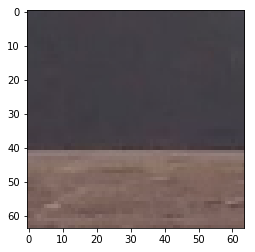

Not a car


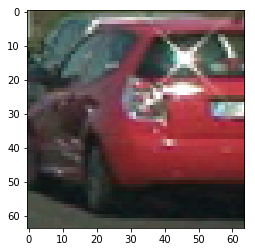

Car


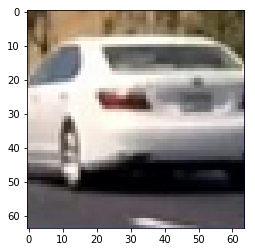

Not a car


In [16]:
image = load_image("data/non-vehicles/Extras/extra55.png")
show_image(image)
res = predict_for_image(image, definition, scaler, svc)
print('Not a car' if res[0] == 0 else 'Car')

image = load_image("data/vehicles/GTI_Right/image0535.png")
show_image(image)
res = predict_for_image(image, definition, scaler, svc)
print('Not a car' if res[0] == 0 else 'Car')

## Sliding Windows

In [17]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_shift=(32, 32)):
    """
    Calculate sliding windows for the image region
    """
    
    shape = img.shape

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
        
    if x_start_stop[1] is None:
        x_start_stop[1]=shape[1]

    if y_start_stop[0] is None:
        y_start_stop[0]=0
        
    if y_start_stop[1] is None:
        y_start_stop[1]=shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    #x_npixels =  xy_window[0] * (1 - xy_overlap[0])
    #y_npixels =  xy_window[1] * (1 - xy_overlap[1])
    x_npixels =  xy_shift[0]
    y_npixels =  xy_shift[1]
    
    # Compute the number of windows
    #nx = np.int((xspan  - xy_window[0] * xy_overlap[0]) / x_npixels)
    #ny = np.int((yspan  - xy_window[1] * xy_overlap[1]) / y_npixels)
    nx = np.int((xspan  - xy_window[0]) // x_npixels + 1)
    ny = np.int((yspan  - xy_window[1]) // y_npixels + 1)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for i_y in range(ny):
        y_pos = np.int(y_start_stop[0] + y_npixels * i_y)
        for i_x in range(nx):
            x_pos = np.int(x_start_stop[0] + x_npixels * i_x)
            window_list.append(((x_pos, y_pos), (x_pos + xy_window[0], y_pos + xy_window[1])))   
    
    # Return the list of windows
    return window_list

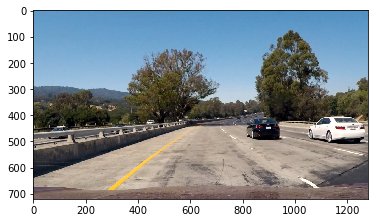

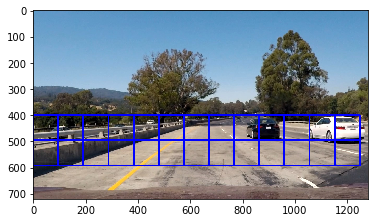

In [18]:
image = load_image("test_images/test1.jpg")
show_image(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 650], 
                    xy_window=(96, 96), xy_shift=(96, 96))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

matplotlib.image.imsave('output_images/windows_search.png', window_img)

# Search Cars

In [29]:
def get_sliding_windows():
    
    
    windows_small = slide_window(image, x_start_stop=[None, None], y_start_stop=[390, 500], 
                    xy_window=(80, 80), xy_shift=(10, 10))

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[390, 620], 
                    xy_window=(100, 100), xy_shift=(20, 20))

    windows_big = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 660],
                        xy_window=(140, 140), xy_shift=(40, 40))

    windows.extend(windows_big)
    windows.extend(windows_small)
    
    return windows


def search_windows(image, windows, clf, definition, scaler):

    #Create an empty list to receive positive detection windows
    on_windows = []
    
    #Iterate over all windows in the list
    for window in windows:
        #Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #Extract features for that window using single_img_features()
        prediction = predict_for_image(test_img, definition, scaler, clf)     
        
        #If positive (prediction == 1) then save the window
        if prediction[0] == 1:
            on_windows.append(window)
            
    return on_windows

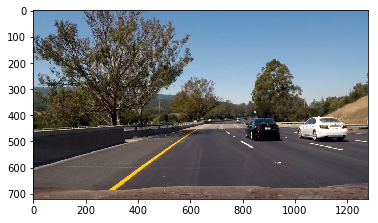

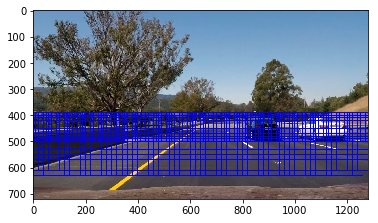

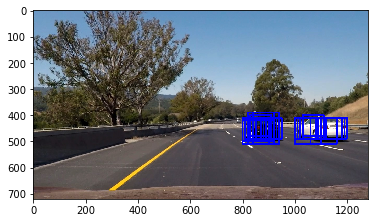

In [31]:
image = load_image("test_images/test6.jpg")
show_image(image)
windows = get_sliding_windows()

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=2)                    
plt.imshow(window_img)
plt.show()

matplotlib.image.imsave('output_images/multiple_windows_search.png', window_img)

detections = search_windows(image, windows, svc, definition, scaler)

window_img = draw_boxes(image, detections, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

matplotlib.image.imsave('output_images/multiple_detections.png', window_img)

## Clustering of detections

In [32]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    
    boxes = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        boxes.append(bbox)
    # Return the image
    return img, boxes

from scipy.ndimage.measurements import label

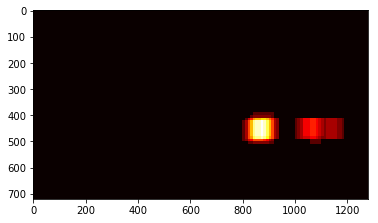

2 cars found


In [ ]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, detections)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap, cmap='hot')
plt.show()

matplotlib.image.imsave('output_images/heat_map.png', heatmap)

labels = label(heatmap)
print(labels[1], 'cars found')

draw_img, _ = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)
plt.show()

matplotlib.image.imsave('output_images/single_detection.png', draw_img)

In [23]:
def detection_pipeline(image, windows, clf, definition, scaler, threshold=0):
    
    #detect cars
    detections = search_windows(image, windows, clf, definition, scaler)
    
    #create hear_map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, detections)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    
    # get labeled clasters
    labels = label(heatmap)
    
    return labels, heatmap

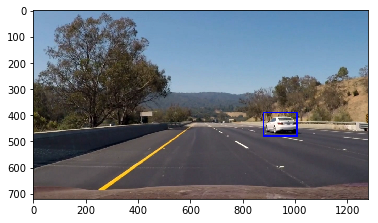

In [24]:
image = load_image("test_images/white.png")
labels, heatmap = detection_pipeline(image, windows, svc, definition, scaler)
draw_img, _ = draw_labeled_bboxes(np.copy(image), labels)
show_image(draw_img)

In [25]:
#prepare environment to work with video
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
class ClipContext():
    def __init__(self):
        self.previous_clusters = []
        self.previous_boxes = []
    
    def process_video(self, clip_input, clip_output):
        clip1 = VideoFileClip(clip_input)
        white_clip = clip1.fl_image(self.process_frame)
        %time white_clip.write_videofile(clip_output, audio=False)

    def process_frame(self, image):
        #remove outdated data
        if len(self.previous_clusters) > 3:
                self.previous_clusters.pop(0)
                #self.previous_boxes.pop(0)
        
        labels, heatmap = detection_pipeline(image, windows, svc, definition, scaler)
        
        self.previous_clusters.append(heatmap)
        
        heat = sum(self.previous_clusters)
        heat = apply_threshold(heat, 3)
            
        labels = label(heat)
        draw_img, box = draw_labeled_bboxes(np.copy(image), labels)
        
        #show_image(draw_img)
        
        return draw_img

In [27]:
context = ClipContext()
clip1_name = "test_video1.mp4"
white_output = 'test_video_updated3.mp4'
context.process_video(clip1_name, white_output)

[MoviePy] >>>> Building video test_video_updated3.mp4
[MoviePy] Writing video test_video_updated3.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 38/39 [02:04<00:03,  3.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_updated3.mp4 

Wall time: 2min 4s


In [28]:
context = ClipContext()
clip1_name = "project_video.mp4"
white_output = 'project_video_updated.mp4'
context.process_video(clip1_name, white_output)

[MoviePy] >>>> Building video project_video_updated.mp4
[MoviePy] Writing video project_video_updated.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:09:11<00:03,  3.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_updated.mp4 

Wall time: 1h 9min 12s
